In [1]:
import numpy as np
import pandas as pd
import os
from shutil import copyfile
import pickle
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import colorlover as cl


import neuro_morpho_toolbox as nmt
%matplotlib inline

F:\Users\zzjun\Anaconda3\lib\site-packages\neuro_morpho_toolbox-0.1-py3.7.egg\neuro_morpho_toolbox\
Loading CCF Atlas data...
Loading time: 0.64
Loading CCF brain structure data...
Loading time: 0.00
Loading selected CCF Atlas and Contour data...
Loading time: 1.01


```
import pickle
ns = nmt.neuron_set(r'D:\Handover_Zijun\Janelia_1000_rm')
pickle.dump([ns], open("D:\\Songlin\\Janelia_ns.pickle", "wb"))
```

### read neuron and SUB_list in

In [2]:
import pickle
import pickle


pickle_in = open("D:\\Songlin\\Janelia_ns_flip.pickle","rb")
[ns] = pickle.load(pickle_in)
SUB_list = ns.metadata[ns.metadata.SomaRegion=='SUB'].index.tolist()

In [3]:
selectedNS= ns.metadata[ns.metadata['CellType']== 'SUB']
#selectedNS = selectedNS.append(ns.metadata[ns.metadata['CellType']== 'ProS'])
SUB_list = ns.metadata[ns.metadata.SomaRegion=='SUB'].index.tolist()

### read contour in

In [4]:
import pickle
[interestContour] = pickle.load(open('D:/Songlin/interest_contour.pickle', 'rb'))
[interestArray] = pickle.load(open('D:/Songlin/interest_Arr.pickle', 'rb'))

### Set region names

In [5]:
related_region_name =['CA1','SUB','ProS','MM','AV','ENTm','RE','AM','ENTl','PL','BLA','ILA','COAp','COAa','TR','RSPv','OT','LSc','LSv','LSr','BST']

related_region_id = list(map(nmt.bs.name_to_id, related_region_name))

selected_region_name =  ['CA1','SUB','ProS']
selected_region_id = list(map(nmt.bs.name_to_id, selected_region_name))

### Set region_color_dict
* Consider all the related_region_id 
* Only selected_region_id will be different from others

In [6]:
# Global variables
u_views = ['Coronal', 'Horizontal', 'Sagittal']
#u_color_by = ['SingleCell', 'CellType', 'Subtype', 'Cluster', 'nblast']


view_idx = dict(zip(u_views, [0, 1, 2]))
view_axis = dict(zip(u_views, ["X", "Y", "Z"]))

midline = nmt.annotation.micron_size['z']/2

# Custom settings
# related_region_id includes 19 regions, initialize color to C0
region_color_dict = dict(zip(related_region_id, ["C0" for i in range(len(related_region_id))]))

# Initialize selected regions' color to C1-C7, 7 is len(selected)
for i,cur_region in enumerate(selected_region_id):
    region_color_dict[cur_region] = "C"+str(i+1)

# Set child region to have the same color
for cur_region in related_region_id:
    for cur_child in nmt.bs.get_all_child_id(cur_region):
        region_color_dict[cur_child] = region_color_dict[cur_region]
region_color_dict[0] ='C0'


### fun plot_swc_mpl used to plot swc segment

In [7]:
def plot_swc_mpl(segment, specific_L,
                 color='rgb(255, 0, 0)', view_by='Horizontal',
                 linewidth=1, alpha=1,
                 ax=None):
    assert view_by in u_views, " ".join((["option 'view_by' should be one of the following: "] + u_views))
    Xe, Ye, Ze, Te = segment
    specific_Dic = { temp_Region[i] : i+1 for i in range(0, len(temp_Region)) }
    #print('The specific axon regions for this neuron is '+str(specific_L))
    if view_by == "Coronal":
        tp = pd.DataFrame({'heng': Ze, 'zong': Ye, 'Te': Te})
    if view_by == "Horizontal":
        tp = pd.DataFrame({'heng': Ze, 'zong': Xe, 'Te': Te})
    if view_by == "Sagittal":
        tp = pd.DataFrame({'heng': Xe, 'zong': Ye, 'Te': Te})

    if ax is None:
        fig, ax = plt.subplots(1, 1)

    if color == "classical":
        ax.plot(tp.heng[tp.Te == 2], tp.zong[tp.Te == 2], c='r', linewidth=linewidth, alpha=alpha)
        ax.plot(tp.heng[tp.Te == 3], tp.zong[tp.Te == 3], c='b', linewidth=linewidth, alpha=alpha)
        ax.plot(tp.heng[tp.Te == 4], tp.zong[tp.Te == 4], c='magenta', linewidth=linewidth, alpha=alpha)
    if color.startswith('rgb'):
        ax.plot(tp.heng, tp.zong,
                c=rgb_to_list(color),
                linewidth=linewidth, alpha=alpha)
    if isinstance(color, list):
        ax.plot(tp.heng, tp.zong,
                c=color,
                linewidth=linewidth, alpha=alpha)
    # The following part is customized for this script
    if color == 'region':
        # The 'type' slot is regarded as 'region id'
        u_regions = sorted(list(set(Te)))
        for i,cur_region in enumerate(u_regions):
            if cur_region == 0:
                cur_name = 'Others'
                ax.plot(tp.heng[tp.Te == cur_region], 
                            tp.zong[tp.Te == cur_region], 
                            c=region_color_dict[cur_region], 
                            linewidth=linewidth, alpha=alpha,
                            label= 'Others',
                           )           
            elif nmt.bs.id_to_name(cur_region) in specific_L:
                cur_name = nmt.bs.id_to_name(cur_region)
                ax.plot(tp.heng[tp.Te == cur_region], 
                            tp.zong[tp.Te == cur_region], 
                            c=region_color_dict[cur_region], 
                            linewidth=linewidth, alpha=alpha,
                            label=cur_name + '_'+str(specific_Dic[cur_name]),
                           )                
            else:
                cur_name = nmt.bs.id_to_name(cur_region)#"Others"
#             print(cur_region, region_color_dict[cur_region])
                ax.plot(tp.heng[tp.Te == cur_region], 
                            tp.zong[tp.Te == cur_region], 
                            c=region_color_dict[cur_region], 
                            linewidth=linewidth, alpha=alpha,
                            label=cur_name,
                           )

#     tp = tp[(tp["Te"] == 1)]
#     ax.scatter(tp.heng, tp.zong,
#                c='black',
#                marker="o",
#                s=30)
    ax.legend(loc='upper left')
    return

# def axon_slice(neuron_name, x_position, ax, slice_thickness=250):
#     # 1. Extract branches in cortex
#     neuron = nmt.neuron(swc_path+neuron_name+'.swc')
#     df = neuron.swc.copy()
#     tp = cortex_region_array[
#         np.array(df.x/25, dtype=int).reshape(-1,),
#         np.array(df.y/25, dtype=int).reshape(-1,),
#         np.array(df.z/25, dtype=int).reshape(-1,),
#     ]
#     df['type'] = tp

#     # Horizontal
#     segment = nmt.swc_to_edges(df, keep_invalid=True)
#     plot_swc_mpl(segment, color='region', view_by='Horizontal', ax=ax[0])
#     show_background('Horizontal', int(4000/25), ax=ax[0])

#     df_list = (df[((df.x<(x_position[0]+slice_thickness)) & (df.x>(x_position[0]-slice_thickness)))], 
#                df[((df.x<(x_position[1]+slice_thickness)) & (df.x>(x_position[1]-slice_thickness)))])
#     ax[0].hlines(x_position, 0, nmt.annotation.micron_size['z'], linestyles='dashed', colors='k')

#     # 3. Add border lines
#     for i in range(2):
#         segment = nmt.swc_to_edges(df_list[i], keep_invalid=True)
#         plot_swc_mpl(segment, color='region', view_by='Coronal', ax=ax[i+1])
#         border_line('Coronal', int(x_position[i]/25), 
#                     regions=[1], 
#                     ax=ax[i+1])
#         ax[i+1].set_xlim(0, 6000)
#         ax[i+1].set_ylim(0, 6000)
#         ax[i+1].invert_yaxis()
    
#     return

# fig, ax = plt.subplots(1,3, figsize=(24,8))
# axon_slice('17302_00076', x_position=(7750, 8500), ax=ax, slice_thickness=slice_thickness) #######


In [8]:
def checkplot(segment, specific_L,
                 color='rgb(255, 0, 0)', view_by='Horizontal',
                 linewidth=1, alpha=1,
                 ax=None):
    assert view_by in u_views, " ".join((["option 'view_by' should be one of the following: "] + u_views))
    Xe, Ye, Ze, Te = segment
    specific_Dic = { temp_Region[i] : i+1 for i in range(0, len(temp_Region)) }
    #print('The specific axon regions for this neuron is '+str(specific_L))
    if view_by == "Coronal":
        tp = pd.DataFrame({'heng': Ze, 'zong': Ye, 'Te': Te})
    if view_by == "Horizontal":
        tp = pd.DataFrame({'heng': Ze, 'zong': Xe, 'Te': Te})
    if view_by == "Sagittal":
        tp = pd.DataFrame({'heng': Xe, 'zong': Ye, 'Te': Te})

    if ax is None:
        fig, ax = plt.subplots(1, 1)

    if color == "classical":
        ax.plot(tp.heng[tp.Te == 2], tp.zong[tp.Te == 2], c='r', linewidth=linewidth, alpha=alpha)
        ax.plot(tp.heng[tp.Te == 3], tp.zong[tp.Te == 3], c='b', linewidth=linewidth, alpha=alpha)
        ax.plot(tp.heng[tp.Te == 4], tp.zong[tp.Te == 4], c='magenta', linewidth=linewidth, alpha=alpha)
    if color.startswith('rgb'):
        ax.plot(tp.heng, tp.zong,
                c=rgb_to_list(color),
                linewidth=linewidth, alpha=alpha)
    if isinstance(color, list):
        ax.plot(tp.heng, tp.zong,
                c=color,
                linewidth=linewidth, alpha=alpha)
    # The following part is customized for this script
    if color == 'region':
        # The 'type' slot is regarded as 'region id'
        u_regions = sorted(list(set(Te)))
    if all(x == 0 for x in u_regions):
        return False
    else:
        return True

### fun border_line2 used to plot border colorfully


In [9]:
import colorlover as cl
from neuro_morpho_toolbox.plot import rgb_to_list
def get_single_region_colors(region_list, palette="paired", return_str=False):
    bupu = cl.scales['9']['seq']['BuPu']           
    greens = cl.scales['9']['seq']['Greens']        
    set2 = cl.scales['7']['qual']['Set2']           
    spectral = cl.scales['9']['div']['Spectral']   
    paired = cl.scales['10']['qual']['Paired']     
    mpl_colors = []
    for i in range(9):
        tp = []
        for j in list(mpl.colors.to_rgb("C" + str(i))):
            tp.append(str(int(j * 255)))
        tp = ", ".join(tp)
        tp = "rgb(" + tp + ")"
        mpl_colors.append(tp)
    
    my_palette_dict = {"bupu":bupu,
                   "greens":greens,
                   "set2":set2,
                   "spectral":spectral,
                   "paired":paired,
                   "matplotlib":mpl_colors
                   }    
    margin=0.05
    u_regions = list(set(region_list))
    color_list = cl.to_rgb(cl.interp(my_palette_dict[palette], len(u_regions)))
    if not return_str:
        color_list = [rgb_to_list(i) for i in color_list]
    group_colors = dict(zip(u_regions, color_list))
    return group_colors



ccf_Contour = np.multiply(nmt.ccfArray,nmt.Contour01)
import matplotlib as mpl
def border_line2(view, position, regions=None, ax=None, bkground_ON = False):
    bupu = cl.scales['9']['seq']['BuPu']           
    greens = cl.scales['9']['seq']['Greens']        
    set2 = cl.scales['7']['qual']['Set2']           
    spectral = cl.scales['9']['div']['Spectral']   
    paired = cl.scales['10']['qual']['Paired']     
    mpl_colors = []
    for i in range(9):
        tp = []
        for j in list(mpl.colors.to_rgb("C" + str(i))):
            tp.append(str(int(j * 255)))
        tp = ", ".join(tp)
        tp = "rgb(" + tp + ")"
        mpl_colors.append(tp)
    
    my_palette_dict = {"bupu":bupu,
                   "greens":greens,
                   "set2":set2,
                   "spectral":spectral,
                   "paired":paired,
                   "matplotlib":mpl_colors
                   }    
    margin=0.05
    dpi=80
    enlarge=1.5
    alpha=0.5
    ccf_annotation = nmt.annotation
    # Background image
    nda = np.empty([0, 0])
    xspace = 0
    yspace = 0
    if view.lower() == "coronal":
        nda = (np.max(ccf_annotation.array, axis=0) > 0)  # 3D -> 2D projection
        xspace = ccf_annotation.space['z']
        yspace = ccf_annotation.space['y']
    if view.lower() == "horizontal":
        nda = (np.max(ccf_annotation.array, axis=1) > 0)
        xspace = ccf_annotation.space['z']
        yspace = ccf_annotation.space['x']
    if view.lower() == "sagittal":
        nda = (np.max(ccf_annotation.array, axis=2) > 0).transpose()
        xspace = ccf_annotation.space['y']
        yspace = ccf_annotation.space['x']

    xsize = nda.shape[1]
    ysize = nda.shape[0]

    # Figure settings
    if ax is None:
        figsize = (1 + margin) * xsize * enlarge / dpi, (1 + margin) * ysize * enlarge / dpi
        fig = plt.figure(figsize=figsize, dpi=dpi)
        # Make the axis the right size...
        ax = fig.add_axes([margin, margin, 1 - 2 * margin, 1 - 2 * margin])

    extent = (0, xsize * xspace, ysize * yspace, 0)
    if bkground_ON:
        ax.imshow(nda, cmap="Greys", alpha=0.1, extent=extent)
    else:
        ax.imshow(nda, cmap="Greys", alpha=0.0, extent=extent)
    if regions != None:
        regionDIC = get_single_region_colors(regions, palette="paired", return_str=False)
        regionDIC = {'MM': [1.0, 0.7137254901960784, 0.7568627450980392], 
                     'AM': [0.8470588235294118, 0.7490196078431373, 0.8470588235294118], 
                     'COAa': [0.5411764705882353, 0.16862745098039217, 0.8862745098039215], 
                     'BLA': [0.9019607843137255, 0.9019607843137255, 0.9803921568627451], 
                     'OT': [0.2549019607843137, 0.4117647058823529, 0.8823529411764706],
                     'LSv': [0.6901960784313725, 0.7686274509803922, 0.8705882352941177], 
                     'LSc': [0.0, 0.5019607843137255, 0.5019607843137255], 
                     'ENTm': [0.11764705882352941, 0.5647058823529412, 1.0], 
                     'BST': [0.0, 0.807843137254902, 0.8196078431372549], 
                     'AV': [0.5294117647058824, 0.807843137254902, 0.9803921568627451], 
                     'RE': [1.0, 0.6470588235294118, 0.0], 'ENTl': [0.9803921568627451, 0.9803921568627451, 0.8235294117647058],
                     'TR': [0.1803921568627451, 0.5450980392156862, 0.3411764705882353], 
                     'SUB': [0.5294117647058824, 0.807843137254902, 0.9215686274509803], 
                     'LSr': [1.0, 0.6274509803921569, 0.47843137254901963], 
                     'CA1': [1.0, 0.8431372549019608, 0.0],#gold color instead of yellow 
                     'PL': [0.6627450980392157, 0.6627450980392157, 0.6627450980392157], 
                     'RSPv': [0.6901960784313725, 0.8784313725490196, 0.9019607843137255], 
                     'COAp': [0.5647058823529412, 0.9333333333333333, 0.5647058823529412], 
                     'ILA': [0.4980392156862745, 1.0, 0.6666666666666666], 'ProS': [0.9411764705882353, 1.0, 1.0]}
        regionDIC.update({"SUB":'red',"ProS":'green'})#,"CA1":'yellow'})
        #print(regionDIC)
        if view.lower() == "coronal":    #x   z,y
            #assert position.all() < nmt.annotation.array.shape[0],"Input position must within the brain region"
            for iter_Region in regions:
                x_range = np.array([])
                y_range = np.array([])
                if type(iter_Region) == str:
                    x_range = np.append(x_range,np.where(ccf_Contour[position,:,:] == nmt.bs.name_to_id(iter_Region))[1])
                    y_range = np.append(y_range,np.where(ccf_Contour[position,:,:] == nmt.bs.name_to_id(iter_Region))[0])
                    ax.scatter(xspace * x_range, yspace* y_range, marker="o",s=0.05,c = regionDIC[iter_Region])
        if view.lower() == "horizontal": #y z,x
            #assert position.all() < nmt.annotation.array.shape[1],"Input position must within the brain region"
            for iter_Region in regions:
                x_range = np.array([])
                y_range = np.array([])
                if type(iter_Region) == str:
                    x_range = np.append(x_range,np.where(ccf_Contour[:,position,:] == nmt.bs.name_to_id(iter_Region))[1])
                    y_range = np.append(y_range,np.where(ccf_Contour[:,position,:] == nmt.bs.name_to_id(iter_Region))[0])
                    ax.scatter(xspace * x_range, yspace* y_range, marker="o",s=0.05,c = regionDIC[iter_Region])
        if view.lower() == "sagittal":   #z  y,x
            #assert position.all() < nmt.annotation.array.shape[2],"Input position must within the brain region"
            for iter_Region in regions:
                x_range = np.array([])
                y_range = np.array([])
                if type(iter_Region) == str:
                    x_range = np.append(x_range,np.where(ccf_Contour[:,:,position] == nmt.bs.name_to_id(iter_Region))[0])
                    y_range = np.append(y_range,np.where(ccf_Contour[:,:,position] == nmt.bs.name_to_id(iter_Region))[1])
                    ax.scatter(xspace * x_range, yspace* y_range, marker="o",s=0.05,c = regionDIC[iter_Region])
    return

def swc_to_edges2(swc, keep_invalid=True):
    '''
    :param swc: a dataframe from the attribute of the neuron object (see ./swc.py neuron.swc).
    :return: a list of node coordinates and attributes for the convenience of plotting
    '''

    # 1. Get all edges
    all_nodes = tp.index.tolist()#922
    children = tp.index[tp.parent.isin(all_nodes)].tolist()#900
    parents = tp.loc[children, "parent"].tolist()#918
    children = tp.loc[children, :].index.tolist()
    N = len(children)
    cuts = [None] * N

    # 2. Create a dataframe with all edges
    # each edge is represented as 3 consecutive rows: [child, parent, empty]
    res = pd.DataFrame(columns=['x', 'y', 'z', 'type'],
                       index=range(N * 3)
                       )
    children_id = np.arange(N) * 3
    parents_id = np.arange(N) * 3 + 1
    cuts_id = np.arange(N) * 3 + 2

    # 2.1. Location columns

    for cur_col in ['x', 'y', 'z']:
        res.loc[children_id, cur_col] = swc.loc[children, cur_col].tolist()
        res.loc[parents_id, cur_col] = swc.loc[parents, cur_col].tolist()
    res.loc[cuts_id, ['x', 'y', 'z']] = None

    # 2.2 Type column
    res.loc[children_id, 'type'] = swc.loc[children, 'type'].tolist()
    res.loc[parents_id, 'type'] = swc.loc[children, 'type'].tolist()  # Use child type to represent a segment
    res.loc[cuts_id, 'type'] = swc.loc[children, 'type'].tolist()
    # Soma type
    soma_list = swc[swc.type == 1].index.tolist()
    if len(soma_list) > 0:
        i_soma = [parents_id[parents.index(i)] for i in soma_list if i in parents]
        res.loc[i_soma, 'type'] = 1
    # Invalid types
    res.loc[~res.type.isin([1, 2, 3, 4]), "type"] = 0
    if not keep_invalid:
        res = res[res.type != 0]
    # Output
    Xe = res.x.tolist()
    Ye = res.y.tolist()
    Ze = res.z.tolist()
    Te = res.type.tolist()

    return [Xe, Ye, Ze, Te]


In [10]:
### func swc_to_edges2 mapped 

In [11]:
def swc_to_edges2(swc, keep_invalid=True):
    '''
    :param swc: a dataframe from the attribute of the neuron object (see ./swc.py neuron.swc).
    :return: a list of node coordinates and attributes for the convenience of plotting
    '''

    # 1. Get all edges
    all_nodes = swc.index.tolist()
    children = swc.index[swc.parent.isin(all_nodes)].tolist()
    N = len(children)
    parents = swc.loc[children, "parent"].tolist()
    cuts = [None] * N

    # 2. Create a dataframe with all edges
    # each edge is represented as 3 consecutive rows: [child, parent, empty]
    res = pd.DataFrame(columns=['x', 'y', 'z', 'type'],
                       index=range(N * 3)
                       )
    children_id = np.arange(N) * 3
    parents_id = np.arange(N) * 3 + 1
    cuts_id = np.arange(N) * 3 + 2

    # 2.1. Location columns

    for cur_col in ['x', 'y', 'z']:
        res.loc[children_id, cur_col] = swc.loc[children, cur_col].tolist()
        res.loc[parents_id, cur_col] = swc.loc[parents, cur_col].tolist()
    res.loc[cuts_id, ['x', 'y', 'z']] = None

    # 2.2 Type column
    res.loc[children_id, 'type'] = swc.loc[children, 'type'].tolist()
    res.loc[parents_id, 'type'] = swc.loc[children, 'type'].tolist()  # Use child type to represent a segment
    res.loc[cuts_id, 'type'] = swc.loc[children, 'type'].tolist()
    # Soma type
    soma_list = swc[swc.type == 1].index.tolist()
    if len(soma_list) > 0:
        i_soma = [parents_id[parents.index(i)] for i in soma_list if i in parents]
        res.loc[i_soma, 'type'] = 1
    # Invalid types
    #res.loc[~res.type.isin([1, 2, 3, 4]), "type"] = 0
    if not keep_invalid:
        res = res[res.type != 0]
    # Output
    Xe = res.x.tolist()
    Ye = res.y.tolist()
    Ze = res.z.tolist()
    Te = res.type.tolist()

    return [Xe, Ye, Ze, Te]

In [12]:
    def load_csv_from_path(self, path):
        self.csv_path = path
        self.metadata = pd.DataFrame(columns=['File_name', 'Hemisphere'])
        hemi_dict = {1: initiate_df_dict(), 2: initiate_df_dict()}
        for input_table in sorted(os.listdir(path)):
            df = read_location_table(path, input_table)
            if df is None:
                continue
            cell_name = input_table.replace(".csv", "").replace(".swc", "").replace(".eswc", "")

            # Metadata
            hemi_id = get_hemisphere(df)
            if np.isnan(hemi_id):
                print(input_table)
                continue
            cur_metadata = pd.DataFrame({'File_name':os.path.join(path, input_table),
                                         'Hemisphere':hemi_id
                                         },
                                        index=[cell_name])
            self.metadata = pd.concat([self.metadata, cur_metadata])

            # Feature table
            for i in [1,2]:
                hemi_dict[i] = add_new_record(hemi_dict[i], df, i, cell_name)

        # ipsi_col = ["ipsi_" + nmt.bs.level.loc[i, "Abbreviation"] for i in hemi_dict[1]["soma"].columns.tolist()]
        ipsi_col = ["ipsi_" + nmt.bs.level.loc[i, "Abbreviation"] for i in hemi_dict[1]["axon"].columns.tolist()]
        contra_col = ["contra_" + nmt.bs.level.loc[i, "Abbreviation"] for i in hemi_dict[1]["axon"].columns.tolist()]
        axon_location = pd.DataFrame(index=hemi_dict[1]["axon"].index, columns=ipsi_col + contra_col, dtype='float32')
        # Flip the matrix if hemisphere == 2
        for i in range(len(self.metadata)):
            cell = self.metadata.index[i]
            hemi = self.metadata.Hemisphere[i]
            if hemi == 1:
                axon_location.loc[cell] = hemi_dict[1]["axon"].loc[cell].tolist() + \
                                          hemi_dict[2]["axon"].loc[cell].tolist()
            if hemi == 2:
                axon_location.loc[cell] = hemi_dict[2]["axon"].loc[cell].tolist() + \
                                          hemi_dict[1]["axon"].loc[cell].tolist()
        self.add_raw_data(axon_location)
        return

### func showNeuron to show neurons

In [13]:
#from neuro_morpho_toolbox.plot import border_line
def showNeuron(neuron_name, save, specific_list, slice_thickness = 50, plotF = False):
    ## Merge a cluster
    neuron_df_list = []
    neuron = nmt.neuron(neuron_name+'.swc')
    df = neuron.swc.copy()
    # only select the axonal part
    df = df[df.type==2]
    # neuron_df_list is a list, each element corresponds to the selected axonal segment
    neuron_df_list = neuron_df_list + [df]
    
    # concate all the cell_list's axonal swc into a single df
    # therefore the index of df may have duplicate nodes
    # with columns ['type', 'x', 'y', 'z', 'r', 'parent']
    df = pd.concat(neuron_df_list, axis=0)
    tp = interestArray[
        np.array(df.x/25, dtype=int).reshape(-1,),
        np.array(df.y/25, dtype=int).reshape(-1,),
        np.array(df.z/25, dtype=int).reshape(-1,),
    ]
    # replace axon type 2 with the region ID
    df['type'] = tp
    s_min = int(np.min(df.x) / slice_thickness)
    s_max = int(np.max(df.x) / slice_thickness) + 1

    # Filter out slices without enough axon fibers
    df_slice = pd.DataFrame(index=range(s_min, s_max), columns=['x_center', 'thickness', 'x_min', 'x_max', 'total_branch'])
    for i in range(s_min, s_max):
        x_min = i*slice_thickness
        x_max = (i+1)*slice_thickness
        tp = df[((df.x<(x_max)) & (df.x>(x_min)))]
        df_slice.loc[i] = [
            (i + 0.5) * slice_thickness,
            slice_thickness,
            x_min,
            x_max,
            len(tp)
        ]
    # Filter df_slice
    df_slice = df_slice.astype('float')
    #########HERE just keep al the slice############
    #df_slice = df_slice[df_slice.total_branch>50]

    # Coronal
    corner_block = pd.DataFrame({
        'type':[9999]*4,
        'x':[0]*4,
        'y':[0,6000,0,6000],
        'z':[0,0,6000,6000],
        'r':[1]*4,
        'parent':[-1]*4
        }
    )
    ncol = 6
    nrow = int((len(df_slice)+ncol-1)/ncol)
    # ncol = 2
    # nrow = 2
    fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol, 6*nrow))
    fig.patch.set_facecolor('silver')
    
    ax = ax.reshape(-1,)
    for i,s_id in enumerate(df_slice.index.tolist()[:]):
        tp = df[((df.x>(df_slice.loc[s_id, 'x_min'])) 
                 & (df.x<(df_slice.loc[s_id, 'x_max'])))]
        #tp = pd.concat([tp, corner_block], axis=0)
        segment = swc_to_edges2(tp, keep_invalid=True)
        #segment = nmt.swc_to_edges(tp, keep_invalid=True)
        plot_swc_mpl(segment, specific_list, color='region', view_by='Coronal', ax=ax[i])
        ax[i].set_facecolor('silver')
        ax[i].set_xlim(0, 6000)
        ax[i].set_ylim(0, 6000)
        #sns.kdeplot(tp.z, tp.y, shade=True, ax=ax[i], cmap='gnuplot2', bw=25)
#         ax[i].scatter(tp.z, tp.y, alpha=0.8, color='r', s=1)
        border_line2('Coronal', int(df_slice.loc[s_id, 'x_center'] / 25), 
                    ax=ax[i],
                    regions=related_region_name
                   )
        ax[i].text(5000, 5800, "X="+str(int(df_slice.loc[s_id, 'x_center'])), color='w')
        ax[i].invert_yaxis()
        
    #for i in range(nrow*ncol):
        #ax[i].axis('off')
    if plotF:
        fig.savefig(save, bbox_inches='tight', facecolor=fig.get_facecolor(), edgecolor='none')
    return

#     for i in range(len(neuron_name), ncol*nrow):
#         ax[i].axis('off')
#     if plotF:
#         fig.savefig(save, bbox_inches='tight')
#     return



### Generate big graph for SUB
```Python
folderpath = r'D:\Handover_Zijun\Janelia_1000_flip'

savepath = r'D:\Songlin\23Jan'


for i_neuron in SUB_list:
    selected_DF = pd.DataFrame(ns.features['projection_features'].raw_data.loc[os.path.join(folderpath,i_neuron),:])
    selected_DF = selected_DF[(selected_DF[selected_DF.columns] >0).all(axis=1)]
    selected_DF.sort_values(selected_DF.columns[0], ascending=False)
    temp_Region = selected_DF.index.tolist()
    temp_Region =[x[5:] for x in temp_Region]
    folder = os.path.exists(os.path.join(savepath,'SUB'))
    if not folder:         
        os.makedirs(os.path.join(savepath,'SUB'))     
    showNeuron(i_neuron, os.path.join(os.path.join(savepath,'SUB'),'SUB_'+ str(i_neuron.split('\\')[-1])+'.png'),temp_Region, slice_thickness = 100, plotF = True)
    print('Successfully generating ' + str(i_neuron))
```

### Generate big graph for CA1
```Python
CA1_list = ns.metadata[ns.metadata.SomaRegion=='CA1'].index.tolist()
folderpath = r'D:\Handover_Zijun\Janelia_1000_flip'

savepath = r'D:\Songlin\23Jan'


for i_neuron in CA1_list:
    selected_DF = pd.DataFrame(ns.features['projection_features'].raw_data.loc[os.path.join(folderpath,i_neuron),:])
    selected_DF = selected_DF[(selected_DF[selected_DF.columns] >0).all(axis=1)]
    selected_DF.sort_values(selected_DF.columns[0], ascending=False)
    temp_Region = selected_DF.index.tolist()
    temp_Region =[x[5:] for x in temp_Region]
    folder = os.path.exists(os.path.join(savepath,'CA1'))
    if not folder:         
        os.makedirs(os.path.join(savepath,'CA1'))     
    showNeuron(i_neuron, os.path.join(os.path.join(savepath,'CA1'),'CA1_'+ str(i_neuron.split('\\')[-1])+'.png'),temp_Region, slice_thickness = 100, plotF = True)
    print('Successfully generating ' + str(i_neuron))
```

### Generate big graph for ProS
```Python
ProS_list = ns.metadata[ns.metadata.SomaRegion=='ProS'].index.tolist()
folderpath = r'D:\Handover_Zijun\Janelia_1000_flip'

savepath = r'D:\Songlin\23Jan'


for i_neuron in ProS_list:
    selected_DF = pd.DataFrame(ns.features['projection_features'].raw_data.loc[os.path.join(folderpath,i_neuron),:])
    selected_DF = selected_DF[(selected_DF[selected_DF.columns] >0).all(axis=1)]
    selected_DF.sort_values(selected_DF.columns[0], ascending=False)
    temp_Region = selected_DF.index.tolist()
    temp_Region =[x[5:] for x in temp_Region]
    folder = os.path.exists(os.path.join(savepath,'ProS'))
    if not folder:         
        os.makedirs(os.path.join(savepath,'ProS'))     
    showNeuron(i_neuron, os.path.join(os.path.join(savepath,'ProS'),'ProS_'+ str(i_neuron.split('\\')[-1])+'.png'),temp_Region, slice_thickness = 100, plotF = True)
    print('Successfully generating ' + str(i_neuron))
```

### Organization of documents
* SUB
    * Each neurons big graph
    * Folder for separate neuron
        * Single plot for the slices
* CA1
* ProS

In [24]:
import shutil
#Copy the big neuron inside each separate folders
for iter_r in ['SUB','ProS','CA1']:
    for iter_graph in os.listdir(os.path.join(savepath, iter_r)):
        if iter_graph.endswith('.png'):
            oldname = os.path.join(os.path.join(savepath, iter_r),iter_graph)
            temp_neuron = iter_graph.split('.')[0].split('_')[1]
            folder = os.path.exists(os.path.join(os.path.join(savepath, iter_r),temp_neuron))
            if not folder:         
                os.makedirs(os.path.join(os.path.join(savepath, iter_r),temp_neuron))
            newname = os.path.join(os.path.join(os.path.join(savepath, iter_r),temp_neuron),iter_graph)
            shutil.copyfile(oldname,newname)

In [26]:
#from neuro_morpho_toolbox.plot import border_line
def showSingleNeuron(neuron_name, save_ori, specific_list, slice_thickness = 100, plotF = False):
    ## Merge a cluster
    neuron_df_list = []
    neuron = nmt.neuron(neuron_name+'.swc')
    df = neuron.swc.copy()
    # only select the axonal part
    df = df[df.type==2]
    # neuron_df_list is a list, each element corresponds to the selected axonal segment
    neuron_df_list = neuron_df_list + [df]
    
    # concate all the cell_list's axonal swc into a single df
    # therefore the index of df may have duplicate nodes
    # with columns ['type', 'x', 'y', 'z', 'r', 'parent']
    df = pd.concat(neuron_df_list, axis=0)
    tp = interestArray[
        np.array(df.x/25, dtype=int).reshape(-1,),
        np.array(df.y/25, dtype=int).reshape(-1,),
        np.array(df.z/25, dtype=int).reshape(-1,),
    ]
    # replace axon type 2 with the region ID
    df['type'] = tp
    s_min = int(np.min(df.x) / slice_thickness)
    s_max = int(np.max(df.x) / slice_thickness) + 1

    # Filter out slices without enough axon fibers
    df_slice = pd.DataFrame(index=range(s_min, s_max), columns=['x_center', 'thickness', 'x_min', 'x_max', 'total_branch'])
    for i in range(s_min, s_max):
        x_min = i*slice_thickness
        x_max = (i+1)*slice_thickness
        tp = df[((df.x<(x_max)) & (df.x>(x_min)))]
        df_slice.loc[i] = [
            (i + 0.5) * slice_thickness,
            slice_thickness,
            x_min,
            x_max,
            len(tp)
        ]
    # Filter df_slice
    df_slice = df_slice.astype('float')
    #########HERE just keep al the slice############
    #df_slice = df_slice[df_slice.total_branch>50]

    # Coronal
    corner_block = pd.DataFrame({
        'type':[9999]*4,
        'x':[0]*4,
        'y':[0,6000,0,6000],
        'z':[0,0,6000,6000],
        'r':[1]*4,
        'parent':[-1]*4
        }
    )
    ncol = 6
    nrow = int((len(df_slice)+ncol-1)/ncol)
    # ncol = 2
    # nrow = 2
    
    for i,s_id in enumerate(df_slice.index.tolist()[:]):
        fig, ax = plt.subplots()
        fig.patch.set_facecolor('silver')
        ax.set_facecolor('silver')
        tp = df[((df.x>(df_slice.loc[s_id, 'x_min'])) 
                 & (df.x<(df_slice.loc[s_id, 'x_max'])))]
        #tp = pd.concat([tp, corner_block], axis=0)
        segment = swc_to_edges2(tp, keep_invalid=True)
        #segment = nmt.swc_to_edges(tp, keep_invalid=True)
        if not checkplot(segment, specific_list, color='region', view_by='Coronal', ax=ax):
            continue
        plot_swc_mpl(segment, specific_list, color='region', view_by='Coronal', ax=ax)
        ax.set_xlim(0, 6000)
        ax.set_ylim(0, 6000)
        #sns.kdeplot(tp.z, tp.y, shade=True, ax=ax, cmap='gnuplot2', bw=25)
#         ax.scatter(tp.z, tp.y, alpha=0.8, color='r', s=1)
        border_line2('Coronal', int(df_slice.loc[s_id, 'x_center'] / 25), 
                    ax=ax,
                    regions=related_region_name
                   )
        ax.text(5000, 5800, "X="+str(int(df_slice.loc[s_id, 'x_center'])), color='w')
        ax.invert_yaxis()
        if plotF:
            fig.savefig(os.path.join(save_ori, neuron_name.split('\\')[-1])+'_'+str(int(df_slice.loc[s_id, 'x_center'] / 25))+'.png', bbox_inches='tight', facecolor=fig.get_facecolor(), edgecolor='none')
    return

#     for i in range(len(neuron_name), ncol*nrow):
#         ax.axis('off')
#     if plotF:
#         fig.savefig(save, bbox_inches='tight')
#     return



### Generate single graph for CA1
```Python
CA1_list = ns.metadata[ns.metadata.SomaRegion=='CA1'].index.tolist()
folderpath = r'D:\Handover_Zijun\Janelia_1000_flip'

savepath = r'D:\Songlin\CA1'
folder = os.path.exists(savepath)
if not folder:         
    os.makedirs(savepath)  

for i_neuron in CA1_list:
    selected_DF = pd.DataFrame(ns.features['projection_features'].raw_data.loc[os.path.join(folderpath,i_neuron),:])
    selected_DF = selected_DF[(selected_DF[selected_DF.columns] >0).all(axis=1)]
    selected_DF.sort_values(selected_DF.columns[0], ascending=False)
    temp_Region = selected_DF.index.tolist()
    temp_Region =[x[5:] for x in temp_Region]
    showSingleNeuron(i_neuron, os.path.join(os.path.join(savepath,'singleNeuron'),'CA1_'+ str(i_neuron.split('\\')[-1])),temp_Region, plotF = True)
    print(i_neuron)
```

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

D:\Handover_Zijun\Janelia_1000_flip\AA0058


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

D:\Handover_Zijun\Janelia_1000_flip\AA0078


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

KeyboardInterrupt: 

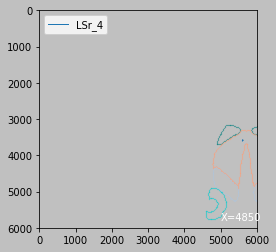

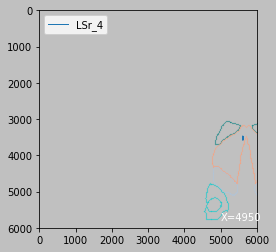

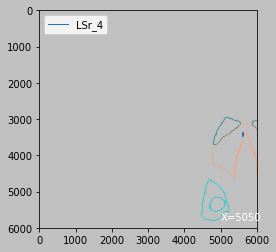

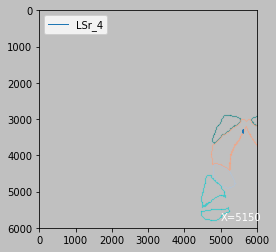

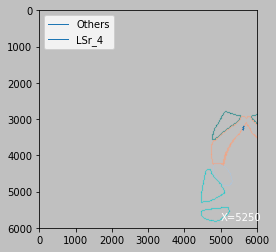

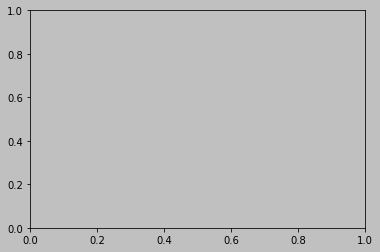

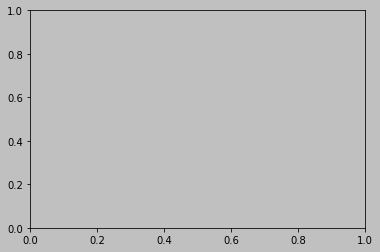

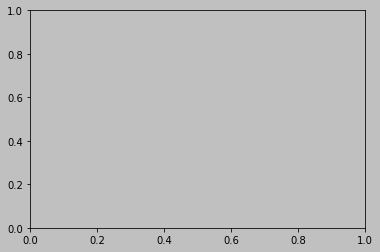

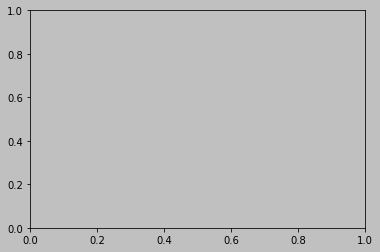

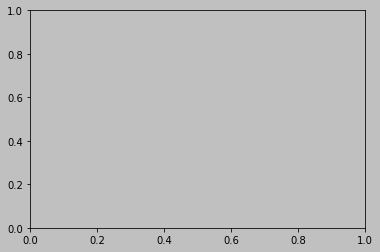

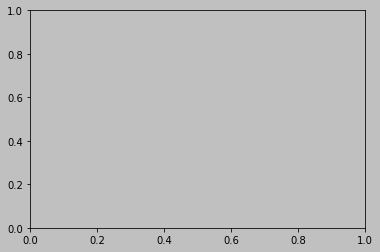

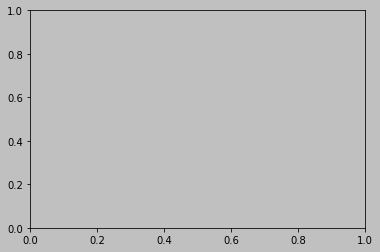

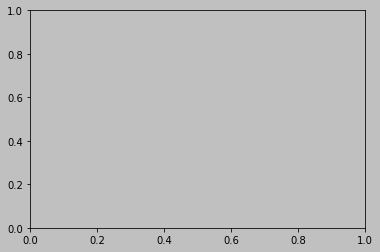

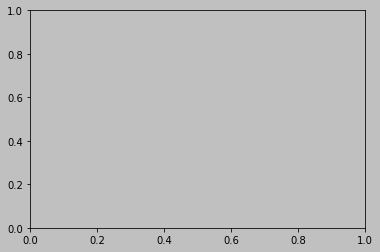

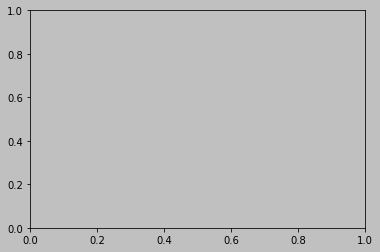

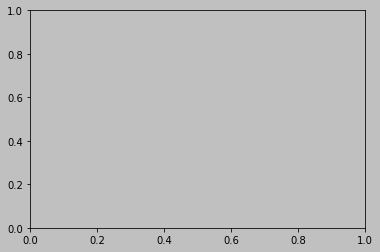

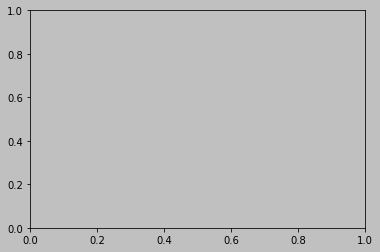

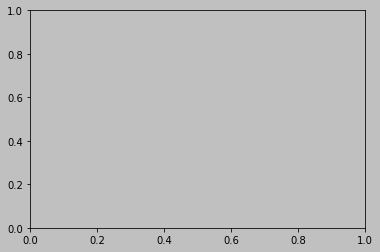

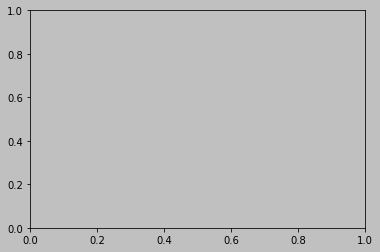

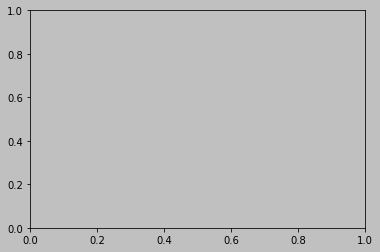

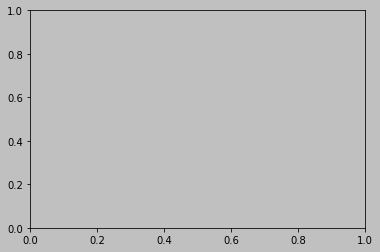

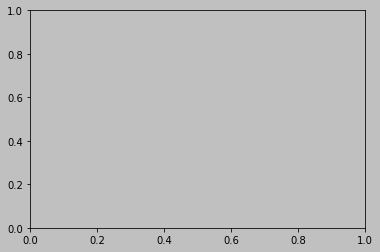

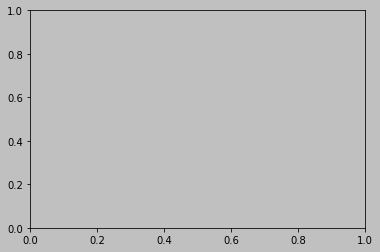

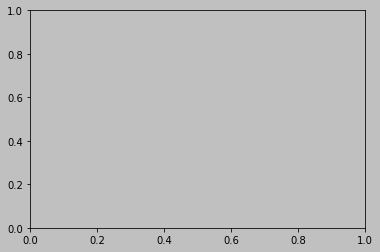

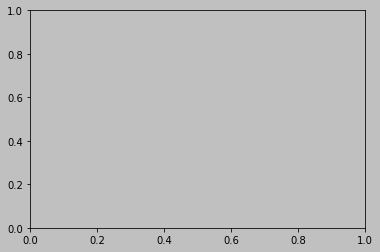

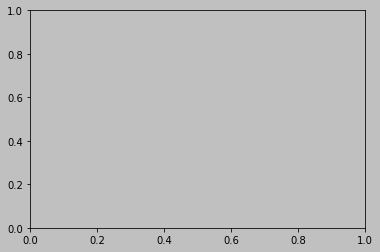

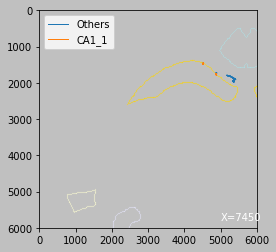

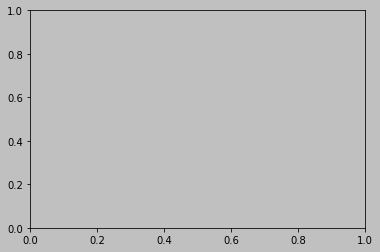

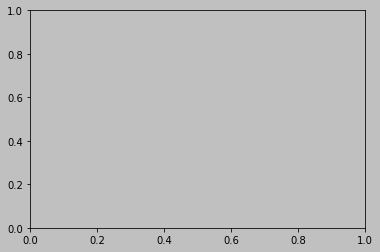

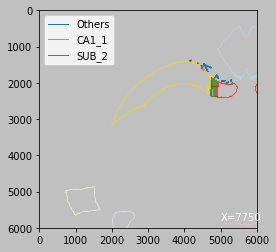

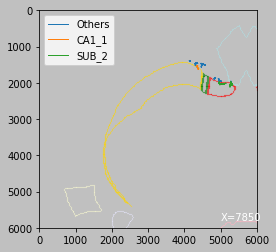

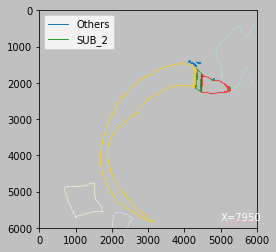

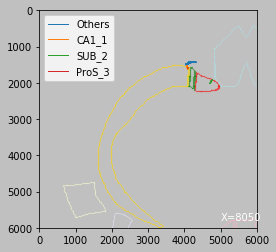

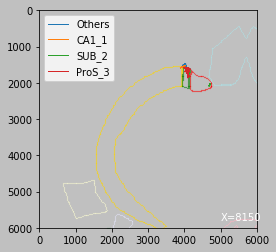

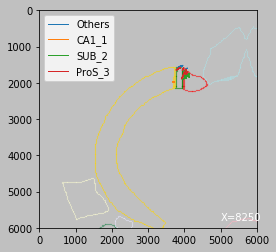

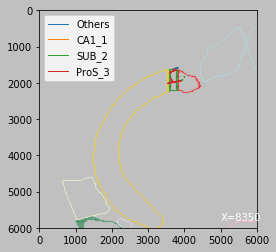

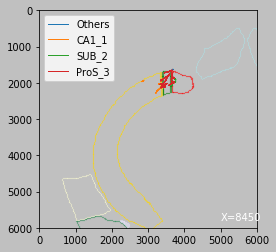

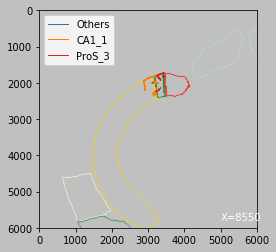

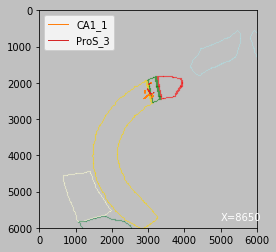

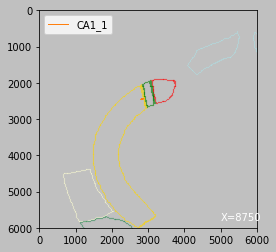

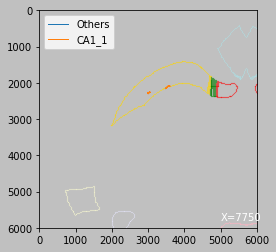

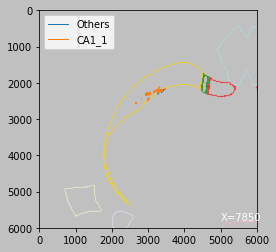

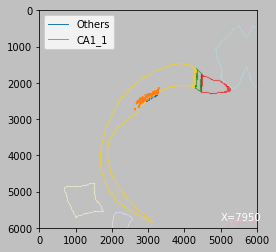

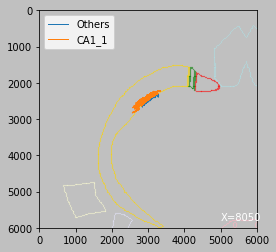

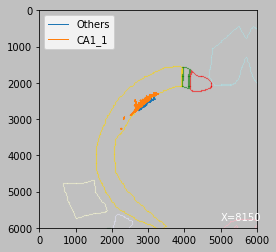

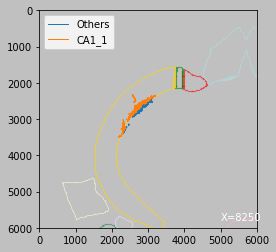

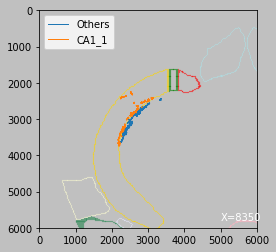

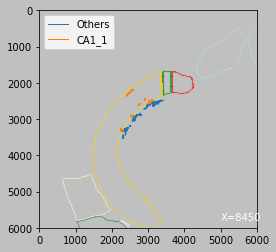

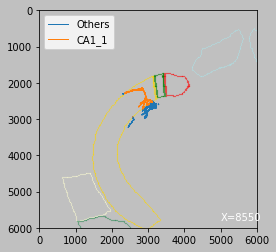

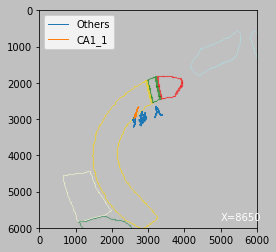

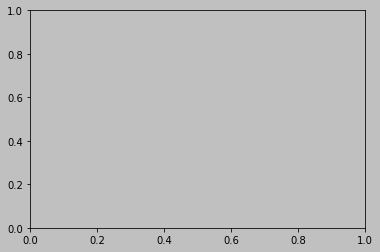

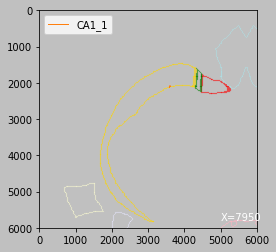

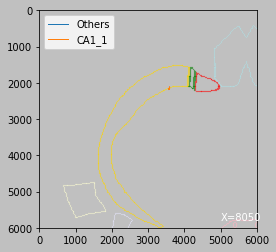

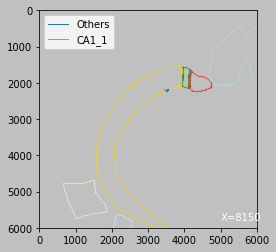

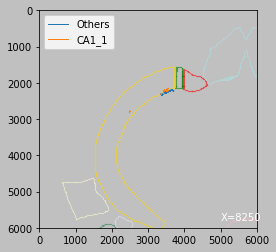

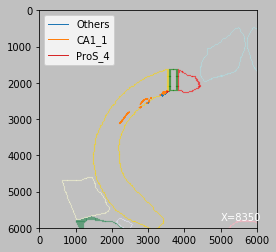

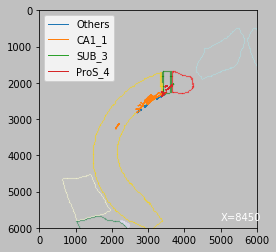

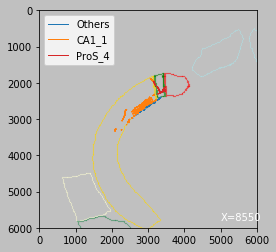

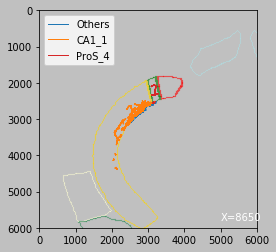

In [28]:
CA1_list = ns.metadata[ns.metadata.SomaRegion=='CA1'].index.tolist()
folderpath = r'D:\Handover_Zijun\Janelia_1000_flip'

savepath = os.path.join(savepath, 'CA1')
folder = os.path.exists(savepath)
if not folder:         
    os.makedirs(savepath)  

for i_neuron in CA1_list:
    selected_DF = pd.DataFrame(ns.features['projection_features'].raw_data.loc[os.path.join(folderpath,i_neuron),:])
    selected_DF = selected_DF[(selected_DF[selected_DF.columns] >0).all(axis=1)]
    selected_DF.sort_values(selected_DF.columns[0], ascending=False)
    temp_Region = selected_DF.index.tolist()
    temp_Region =[x[5:] for x in temp_Region]
    savepath_temp = os.path.join(savepath,i_neuron.split('\\')[-1])
    showSingleNeuron(i_neuron, savepath_temp,temp_Region, slice_thickness = 100,plotF = True)
    print(i_neuron)

In [25]:
str(i_neuron.split('\\')[-1])

'AA0890'

In [ ]:
ProS_list = ns.metadata[ns.metadata.SomaRegion=='ProS'].index.tolist()
folderpath = r'D:\Handover_Zijun\Janelia_1000_flip'

savepath = r'D:\Songlin\ProS'
folder = os.path.exists(savepath)
if not folder:         
    os.makedirs(savepath)  

for i_neuron in ProS_list:
    selected_DF = pd.DataFrame(ns.features['projection_features'].raw_data.loc[os.path.join(folderpath,i_neuron),:])
    selected_DF = selected_DF[(selected_DF[selected_DF.columns] >0).all(axis=1)]
    selected_DF.sort_values(selected_DF.columns[0], ascending=False)
    temp_Region = selected_DF.index.tolist()
    temp_Region =[x[5:] for x in temp_Region]
    showSingleNeuron(i_neuron, os.path.join(savepath,'ProS_'+ str(i_neuron.split('\\')[-1])),temp_Region, plotF = True)
    print(i_neuron)

In [ ]:
SUB_list = ns.metadata[ns.metadata.SomaRegion=='SUB'].index.tolist()
folderpath = r'D:\Handover_Zijun\Janelia_1000_flip'

savepath = r'D:\Songlin\SUB'
folder = os.path.exists(savepath)
if not folder:         
    os.makedirs(savepath)  

for i_neuron in SUB_list:
    selected_DF = pd.DataFrame(ns.features['projection_features'].raw_data.loc[os.path.join(folderpath,i_neuron),:])
    selected_DF = selected_DF[(selected_DF[selected_DF.columns] >0).all(axis=1)]
    selected_DF.sort_values(selected_DF.columns[0], ascending=False)
    temp_Region = selected_DF.index.tolist()
    temp_Region =[x[5:] for x in temp_Region]
    showSingleNeuron(i_neuron, os.path.join(savepath,'SUB_'+ str(i_neuron.split('\\')[-1])),temp_Region, plotF = True)
    print(i_neuron)

### Show three neurons at the same time

In [ ]:
#from neuro_morpho_toolbox.plot import border_line
def show_multi_Neuron(cell_list, save, plotF = False, slice_thickness = 50):
    assert len(cell_list)<4,"Please input less than three neurons at a single time"
    len_df_slice = 0
    s_min = 1000
    s_max = 0
    for neuron_name in cell_list:
        ## Merge a cluster
        neuron_df_list = []
        neuron = nmt.neuron(neuron_name+'.swc')
        df = neuron.swc.copy()
        # only select the axonal part
        df = df[df.type==2]
        # neuron_df_list is a list, each element corresponds to the selected axonal segment
        neuron_df_list = neuron_df_list + [df]

        # concate all the cell_list's axonal swc into a single df
        # therefore the index of df may have duplicate nodes
        # with columns ['type', 'x', 'y', 'z', 'r', 'parent']
        df = pd.concat(neuron_df_list, axis=0)
        tp = interestArray[
            np.array(df.x/25, dtype=int).reshape(-1,),
            np.array(df.y/25, dtype=int).reshape(-1,),
            np.array(df.z/25, dtype=int).reshape(-1,),
        ]
        # replace axon type 2 with the region ID
        df['type'] = tp
        s_min = min(s_min,int(np.min(df.x) / slice_thickness))
        s_max = max(s_max,int(np.max(df.x) / slice_thickness) + 1)

        # Filter out slices without enough axon fibers
        df_slice = pd.DataFrame(index=range(s_min, s_max), columns=['x_center', 'thickness', 'x_min', 'x_max', 'total_branch'])
        for i in range(s_min, s_max):
            x_min = i*slice_thickness
            x_max = (i+1)*slice_thickness
            tp = df[((df.x<(x_max)) & (df.x>(x_min)))]
            df_slice.loc[i] = [
                (i + 0.5) * slice_thickness,
                slice_thickness,
                x_min,
                x_max,
                len(tp)
            ]
        # Filter df_slice
        df_slice = df_slice.astype('float')
        df_slice = df_slice[df_slice.total_branch>50]
        len_df_slice = max(len_df_slice,len(df_slice))
    # Coronal
    corner_block = pd.DataFrame({
        'type':[9999]*4,
        'x':[0]*4,
        'y':[0,6000,0,6000],
        'z':[0,0,6000,6000],
        'r':[1]*4,
        'parent':[-1]*4
        }
    )
    ncol = 6
    nrow = int(((len_df_slice)+ncol-1)/ncol)
    # ncol = 2
    # nrow = 2
    fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol, 6*nrow))
    ax = ax.reshape(-1,)
    for neuron_name in cell_list:
        ## Merge a cluster
        neuron_df_list = []
        neuron = nmt.neuron(neuron_name+'.swc')
        df = neuron.swc.copy()
        # only select the axonal part
        df = df[df.type==2]
        # neuron_df_list is a list, each element corresponds to the selected axonal segment
        neuron_df_list = neuron_df_list + [df]

        # concate all the cell_list's axonal swc into a single df
        # therefore the index of df may have duplicate nodes
        # with columns ['type', 'x', 'y', 'z', 'r', 'parent']
        df = pd.concat(neuron_df_list, axis=0)
        tp = interestArray[
            np.array(df.x/25, dtype=int).reshape(-1,),
            np.array(df.y/25, dtype=int).reshape(-1,),
            np.array(df.z/25, dtype=int).reshape(-1,),
        ]
        # replace axon type 2 with the region ID
        df['type'] = tp


        # Filter out slices without enough axon fibers
        df_slice = pd.DataFrame(index=range(s_min, s_max), columns=['x_center', 'thickness', 'x_min', 'x_max', 'total_branch'])
        for i in range(s_min, s_max):
            x_min = i*slice_thickness
            x_max = (i+1)*slice_thickness
            tp = df[((df.x<(x_max)) & (df.x>(x_min)))]
            df_slice.loc[i] = [
                (i + 0.5) * slice_thickness,
                slice_thickness,
                x_min,
                x_max,
                len(tp)
            ]
            # Filter df_slice
            df_slice = df_slice.astype('float')
            df_slice = df_slice[df_slice.total_branch>50]    


        for i,s_id in enumerate(df_slice.index.tolist()[:]):
            tp = df[((df.x>(df_slice.loc[s_id, 'x_min'])) 
                     & (df.x<(df_slice.loc[s_id, 'x_max'])))]
            #tp = pd.concat([tp, corner_block], axis=0)
            segment = swc_to_edges2(tp, keep_invalid=True)
            #segment = nmt.swc_to_edges(tp, keep_invalid=True)
            plot_swc_mpl(segment, specific_list, color='region', view_by='Coronal', ax=ax[i])
            ax[i].set_xlim(0, 6000)
            ax[i].set_ylim(0, 6000)
            #sns.kdeplot(tp.z, tp.y, shade=True, ax=ax[i], cmap='gnuplot2', bw=25)
    #         ax[i].scatter(tp.z, tp.y, alpha=0.8, color='r', s=1)
            border_line2('Coronal', int(df_slice.loc[s_id, 'x_center'] / 25), 
                        ax=ax[i],
                        regions=related_region_name
                       )
            ax[i].text(5000, 5800, "X="+str(int(df_slice.loc[s_id, 'x_center'])), color='w')
            ax[i].invert_yaxis()
        for i in range(len(neuron_name), ncol*nrow):
            ax[i].axis('off')
    if plotF:
        fig.savefig(save, bbox_inches='tight')
    return



In [ ]:
for i in SUB_list:
    show_multi_Neuron(SUB_list[0:3], 'SUB_heatmap_8Jantt.png', slice_thickness = 200)
    print(i)
    break

In [ ]:
set(segment[3])

In [ ]:
segment[3]

In [ ]:
255,182,193

In [ ]:
sss

In [ ]:
    region_list = related_region_name
    palette="paired"
    bupu = cl.scales['9']['seq']['BuPu']           
    greens = cl.scales['9']['seq']['Greens']        
    set2 = cl.scales['7']['qual']['Set2']           
    spectral = cl.scales['9']['div']['Spectral']   
    paired = cl.scales['10']['qual']['Paired']     
    mpl_colors = []
    for i in range(9):
        tp = []
        for j in list(mpl.colors.to_rgb("C" + str(i))):
            tp.append(str(int(j * 255)))
        tp = ", ".join(tp)
        tp = "rgb(" + tp + ")"
        mpl_colors.append(tp)
    
    my_palette_dict = {"bupu":bupu,
                   "greens":greens,
                   "set2":set2,
                   "spectral":spectral,
                   "paired":paired,
                   "matplotlib":mpl_colors
                   }    
    margin=0.05
    u_regions = list(set(region_list))
    color_list = cl.to_rgb(cl.interp(my_palette_dict[palette], len(u_regions)))
    #color_list = [rgb_to_list(i) for i in color_list]
    #group_colors = dict(zip(u_regions, color_list))

In [ ]:
color_list


In [ ]:
rgbList = ['rgb(255, 182, 193)',  'rgb(216, 191, 216)',  'rgb(138, 43, 226)',  'rgb(230, 230, 250)',  'rgb(65, 105, 225)',  'rgb(176, 196, 222)',  'rgb(0, 128, 128)',  'rgb(30, 144, 255)',  'rgb(0, 206, 209)',  'rgb(135, 206, 250)',  'rgb(255, 165, 0)',  'rgb(250, 250, 210)',  'rgb(46, 139, 87)',  'rgb(135, 206, 235)',  'rgb(255, 160, 122)',  'rgb(240, 230, 140)',  'rgb(169, 169, 169)',  'rgb(176, 224, 230 )',  'rgb(144, 238, 144)',  'rgb(127, 255, 170)',  'rgb(240, 255, 255)']
color_list = [rgb_to_list(i) for i in rgbList]
dict(zip(u_regions,  color_list))